## Проект. Авиарейсы без потерь.
Суть проекта - из базы данных построеной на Postgres SQL содержащей информацию о авиаперевозках по России выделить лишь те данные, анализ которых сможет показать самые убыточные рейсы из аэропорта Анапа (AAQ) в зимний перод 2017 года. 
В задании проекта представлен шаблон запроса, который фильтрует данные по следующим критериям:
- аэропорт - Анапа
- период - январь 2017, февраль 2017, декабрь 2017
- статус рейса - "не отменен"

Полагаясь на здравый смысл, в своем запросе я использовал временной период: декабрь 2016, январь 2017, февраль 2017, т. к. счтитаю неприемлимым разбивать зимний сезон.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

avia = pd.read_csv('query_result_2021-07-14T17_00_22.396237Z.csv',
                  parse_dates=['actual_departure', 'actual_arrival'])

In [4]:
print(avia.shape)

(193, 15)


Для анализа убыточности авиаресов мною был сформирован DataSet, который несет в себе следующую информацию:

flight_id - индидуальный идентификатор рейса;

actual_departure - реальное время вылета;

actual_arrival - реальное время прилета;

departure_airport - аэропорт вылета;

departure_airport - аэропорт прилета;

trevel_time - реальное время перелета;

model - модель самолета осуществлявшего авиаперевозку;

count_of_seats - общее колличество мест в самолете данной модели;

count_bc - общее количество мест бизнес-класса в самолете данной модели;

revenue_bc - прибыль полученную авиаперевозчиком от реализации мест бизнес-класса в данном перелете;

count_ec - общее количество мест эконом-класса в самолете данной модели;

revenue_ec - прибыль полученную авиаперевозчиком от реализации мест эконом-класса в данном перелете;

total_amount - общую прибыль полученную авиаперевозчиком в данном перелете;

unprofitable_place - количество не реализованных мест в данном перелете;

count_of_seats.1 - данный столбец выведен ошибочно

# Очистка данных

In [5]:
avia.drop(['departure_airport','count_of_seats.1'], axis=1, inplace=True) # удаление ошибочно сформированного столбца

В случае отсутсвия веричины 'total_amount' у какого-либо рейса посчитать прибыльность рейса становится невозможным

In [6]:
avia.isnull().sum()

flight_id              0
actual_departure       0
actual_arrival         0
arrival_airport        0
trevel_time            0
model                  0
count_of_seats         0
count_bc              13
revenue_bc            13
count_ec              13
revenue_ec            13
total_amount          13
unprofitable_place    13
dtype: int64

In [38]:
avia.dropna(inplace=True)

# Создаем новые признаки

Для вычисления рентабельности рейсов необходимо создать новый признак "avg_fuel_consumption" - средний расход топлива модели саолета.

In [8]:
def create1(x):
    if x == 'Sukhoi Superjet-100':
        return 1864 # расход топлива Sukhoi Superjet-100, кг/ч
    else:
        return 2960 # расход топлива Boeing 737-300, кг/ч 

avia['avg_fuel_consumption'] = avia['model'].apply(create1)

Для вычисления реального расхода топлива на каждом рейсе вводим признак "real_fuel_consumption"

Формула: Средний разход топлива * Время перелета

In [9]:
avia['real_fuel_consumption'] = round(avia['avg_fuel_consumption'] / 60 * avia['trevel_time'])

Для более точного вычисисления прибыльности авиа рейсов необходи опираться на стоимость авиационного керасина исходя из месяца в котором был запрален самолет, т.к. стоимость авиационного керасина составляла:

декабрь: 38867 рублей за тонну

январь: 41435 рублей за тонну

февраль: 39553 рублей за тонну

In [10]:
avia['month'] = avia['actual_departure'].dt.month

In [11]:
avia['day_of_week'] = avia['actual_departure'].dt.weekday

In [12]:
def creat2(x):
    if x == 12:
        return 38867
    elif x == 1:
        return 41435
    elif x == 2:
        return 39553
        
avia['fuel_coast'] = avia['month'].apply(creat2)
avia['final_fuel_costs'] = avia['real_fuel_consumption'] / 1000 * avia['fuel_coast']

Для окончательного вычисления прибыльности авиа рейса необходимо воспользоваться формулой:

Суммарная стоимость приобретенных билетов - Стоимость топлива затраченного за перелет

Стоимость затраченного топлива = Стоимость топлива * Реальный расход

In [13]:
avia['profitability'] = avia['total_amount'] - avia['final_fuel_costs']
avia.dropna(inplace=True)
avia['profitability'].sort_values(ascending=False)

3      1625241.297
65     1617545.631
31     1609888.832
18     1609193.464
1      1605345.631
          ...     
154     484908.829
107     469030.425
191     452208.829
180     408108.829
128     404830.425
Name: profitability, Length: 180, dtype: float64

# Анализ 

Суммарный доход по каждому из направлений

In [14]:
avia.groupby('arrival_airport')['profitability'].sum()

arrival_airport
EGO    5.293733e+07
SVO    1.233922e+08
Name: profitability, dtype: float64

In [ ]:
Средний доход по каждому из направлений

In [15]:
avia.groupby('arrival_airport')['profitability'].mean()

arrival_airport
EGO    5.881925e+05
SVO    1.371024e+06
Name: profitability, dtype: float64

In [17]:
sorted_avia = avia.sort_values(by='profitability', ascending=True, ignore_index=True)

Ввиду того, что общее количество перелетов за указаный период равно 180 рейсам, для оценки возьмем DataSet состоящий из "первых" 18 рейсов ОТСОРТИРОВАННЫХ по возрастанию величины 'profitability', что составит 10% самых малоприбыльных рейсов. 
# Самые малоприбыльные рейсы

In [22]:
sorted_avia.iloc[:18]

,flight_id,actual_departure,actual_arrival,arrival_airport,trevel_time,model,count_of_seats,count_bc,revenue_bc,count_ec,revenue_ec,total_amount,unprofitable_place,avg_fuel_consumption,real_fuel_consumption,month,day_of_week,fuel_coast,final_fuel_costs,profitability
0,136642,2017-01-30 09:28:00+00:00,2017-01-30 10:17:00+00:00,EGO,98.0,Sukhoi Superjet-100,97,10.0,189000.0,54.0,342000.0,531000.0,33.0,1864,3045.0,1,0,41435,126169.575,404830.425
1,136807,2017-02-23 09:28:00+00:00,2017-02-23 10:18:00+00:00,EGO,100.0,Sukhoi Superjet-100,97,8.0,151200.0,60.0,379800.0,531000.0,29.0,1864,3107.0,2,3,39553,122891.171,408108.829
2,136844,2017-02-28 09:26:00+00:00,2017-02-28 10:16:00+00:00,EGO,100.0,Sukhoi Superjet-100,97,6.0,113400.0,73.0,461700.0,575100.0,18.0,1864,3107.0,2,1,39553,122891.171,452208.829
3,136887,2017-01-20 09:30:00+00:00,2017-01-20 10:19:00+00:00,EGO,98.0,Sukhoi Superjet-100,97,8.0,151200.0,70.0,444000.0,595200.0,19.0,1864,3045.0,1,4,41435,126169.575,469030.425
4,136922,2017-02-11 09:27:00+00:00,2017-02-11 10:17:00+00:00,EGO,100.0,Sukhoi Superjet-100,97,10.0,189000.0,66.0,418800.0,607800.0,21.0,1864,3107.0,2,5,39553,122891.171,484908.829
5,136620,2017-02-17 09:30:00+00:00,2017-02-17 10:19:00+00:00,EGO,98.0,Sukhoi Superjet-100,97,9.0,170100.0,70.0,443400.0,613500.0,18.0,1864,3045.0,2,4,39553,120438.885,493061.115
6,136823,2017-02-05 09:27:00+00:00,2017-02-05 10:18:00+00:00,EGO,102.0,Sukhoi Superjet-100,97,10.0,189000.0,68.0,431400.0,620400.0,19.0,1864,3169.0,2,6,39553,125343.457,495056.543
7,136937,2017-01-03 09:29:00+00:00,2017-01-03 10:19:00+00:00,EGO,100.0,Sukhoi Superjet-100,97,9.0,170100.0,72.0,456000.0,626100.0,16.0,1864,3107.0,1,1,41435,128738.545,497361.455
8,136645,2017-01-05 09:29:00+00:00,2017-01-05 10:20:00+00:00,EGO,102.0,Sukhoi Superjet-100,97,9.0,170100.0,73.0,462900.0,633000.0,15.0,1864,3169.0,1,3,41435,131307.515,501692.485
9,136678,2017-01-28 09:27:00+00:00,2017-01-28 10:17:00+00:00,EGO,100.0,Sukhoi Superjet-100,97,10.0,189000.0,70.0,442200.0,631200.0,17.0,1864,3107.0,1,5,41435,128738.545,502461.455


Из DataSet sorted_avia видно, что обсалютно все убыточные рейсы летают в аэропорт "EGO" г. Белгород, на модели самолета типа: Sukhoi Superjet-100. Месяц внутри сезона, напрямую на прибыльность не влияет, так как малоубыточные рейсы есть во всех 3-х месяцах. 

In [14]:
sorted_avia['month'].value_counts()

12    62
1     62
2     56
Name: month, dtype: int64

Сравнивая параметры моделей самолета, можно заметить, что модель типа Boeing 737-300 имеет больше мест в целом, как и больше мест бизнес-класса. Из этого можно сделать вывод: "Чем больше в солете мест в целом, а также мест бизнес класса, тем прибыльнее рейс"

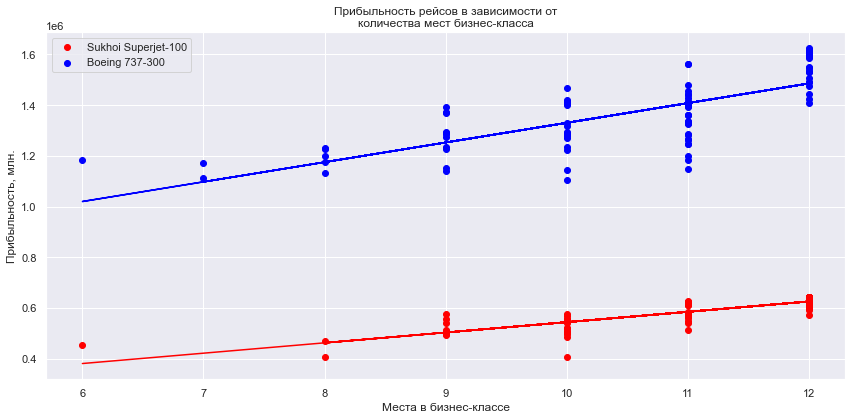

In [15]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(12, 6)) 

for model, color in zip(avia.model, ['red', 'blue']):
    temp_df = avia.loc[avia['model'] == model]
    lr = LinearRegression()
    lr.fit(temp_df['count_bc'].values.reshape(-1, 1), temp_df['profitability'])
    plt.scatter(temp_df['count_bc'], temp_df['profitability'], c=color, label=model)
    plt.plot(temp_df['count_bc'], lr.predict(temp_df['count_bc'].values.reshape(-1, 1)), c=color)

   
plt.title('Прибыльность рейсов в зависимости от\nколичества мест бизнес-класса')
plt.xlabel('Места в бизнес-классе')
plt.ylabel('Прибыльность, млн.')
plt.legend()
plt.tight_layout()
plt.savefig('test.png')
plt.show()

Также стоит проверить общее количество перевезенных пассажиров в разрезе аэропорта назначения.

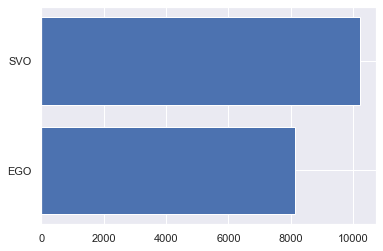

In [53]:
avia['profit_per_seat'] = avia['profitability'] / avia['count_of_seats']
avia['real_seats'] = avia['count_bc'] + avia['count_ec'] # общее количество проданных мест в самолете
g = avia.groupby('arrival_airport')['real_seats'].sum() # соотношение количестве перевезенных граждан от аэропорта назначения
plt.barh(g.index, g.values, )

plt.savefig('pic_1.png')
plt.show()

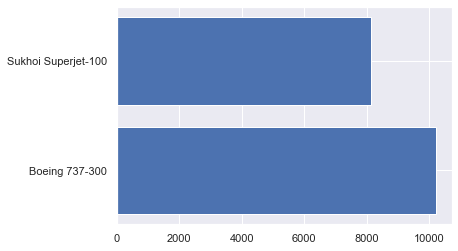

In [56]:
w = avia.groupby('model')['real_seats'].sum()
plt.barh(w.index, w.values, )

plt.savefig('pic_1.png',  bbox_inches = 'tight')
plt.show()

Для полной наглядности стоит проанализировать количество преобретенных билетов эконом-класса, бизнес-класса и не приобретенных билетов.

In [17]:
avia_month = avia.groupby(['month']).sum().reset_index()

In [18]:
avia_month_sort = avia_month.sort_values(by = 'total_amount', ascending=False, ignore_index=True)
avia_month_sort

,month,flight_id,trevel_time,count_of_seats,count_bc,revenue_bc,count_ec,revenue_ec,total_amount,unprofitable_place,avg_fuel_consumption,real_fuel_consumption,fuel_coast,final_fuel_costs,profitability,profit_per_seat,real_seats
0,12,8466397,7446.0,7037,672.0,18488700.0,5684.0,55020100.0,73508800.0,681.0,149544,310868.0,2409754,1.208251e+07,6.142629e+07,520835.155266,6356.0
1,1,8464699,7428.0,7037,673.0,18525300.0,5657.0,54816400.0,73341700.0,707.0,149544,309724.0,2568970,1.283341e+07,6.050829e+07,512733.083922,6330.0
2,2,7646247,6722.0,6356,600.0,16508400.0,5065.0,48977600.0,65486000.0,691.0,135072,280411.0,2214968,1.109110e+07,5.439490e+07,461347.832488,5665.0


Группируем полученные данные

In [19]:
avia_month_sort1 = avia_month_sort[['month','count_bc','count_ec','unprofitable_place']]
avia_month_sort1['month'] = avia_month_sort1['month'].apply(lambda x:{12:'декабрь 2016', 1:'январь 2017', 2:'февраль 2017'}[x])
avia_month_sort1

<ipython-input-19-0c5c8d476cfc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avia_month_sort1['month'] = avia_month_sort1['month'].apply(lambda x:{12:'декабрь 2016', 1:'январь 2017', 2:'февраль 2017'}[x])


,month,count_bc,count_ec,unprofitable_place
0,декабрь 2016,672.0,5684.0,681.0
1,январь 2017,673.0,5657.0,707.0
2,февраль 2017,600.0,5065.0,691.0


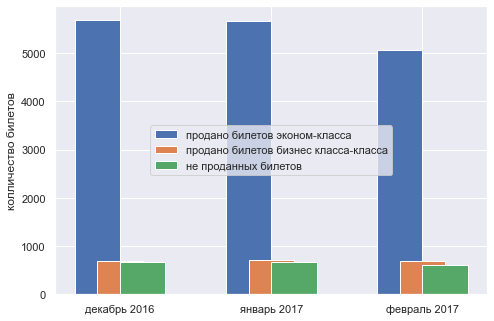

In [31]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])

axes.bar(x = avia_month_sort1['month'], 
         height = avia_month_sort1['count_ec'], 
         width = -0.3, 
         align = 'edge',
         label = 'продано билетов эконом-класса')
axes.bar(x = avia_month_sort1['month'], 
         height = avia_month_sort1['unprofitable_place'], 
         width = 0.3,
         label = 'продано билетов бизнес класса-класса')
axes.bar(x = avia_month_sort1['month'], 
         height = avia_month_sort1['count_bc'], 
         width = 0.3 , 
         align = 'edge',
         label = 'не проданных билетов')
axes.legend(loc = 10)
axes.set_ylabel('колличество билетов')
plt.savefig('pic_1.png', bbox_inches = 'tight')


# Вывод

1. Топ 10 самых убыточных рейсов из Анапы составили рейсы на самолетах модели Sukhoi Superjet-100 в аэропорт г. Белгорода “EGO” на всем временном интервале с декабря по февраль. Оценить прибыльность авиарейсов в г. Новокузнецк “NOZ” не представляется возможным, ввиду отсутствия данных о стоимости билетов и их количества.
2. Выявлена зависимость: увеличение размера прибыли с увеличением количества перевезенных пассажиров.
3. Выявлена зависимость: увеличение размера прибыли с кувеличением количества приобретенных билетов бизнес-класса